# Análisis de CLAP score de generación de audio tasty-musicgen-small

_Análisis comparativo entre prompts originales (no musicales) y reprompts musicales detallados_

---

## Objetivo

Este notebook analiza los resultados de CLAP Score obtenidos al generar audio con el modelo **tasty-musicgen-small** (fine-tuned de musicgen-small) utilizando dos estrategias de prompting:

1. **Prompts originales**: Descripciones de escenarios cotidianos (comida, lugares, emociones)
2. **Reprompts musicales**: Descripciones técnicas detalladas de instrumentos, timbres, y características musicales

El análisis busca determinar la efectividad del modelo para seguir prompts textuales y el impacto del reprompting musical.

## 1. Importar Librerías y Cargar Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import PROJECT_ROOT, load_config, setup_project_paths

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
setup_project_paths()
config = load_config()
CLAP_SCORES_PATH = PROJECT_ROOT / config.data.data_clap_path

In [3]:
prompt_df = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs.csv'))
reprompt_df = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_reprompt_outputs.csv'))

print(f"Dataset Prompts Originales: {prompt_df.shape}")
print(f"Dataset Reprompts Musicales: {reprompt_df.shape}")

Dataset Prompts Originales: (80, 4)
Dataset Reprompts Musicales: (80, 4)


In [4]:
print("PROMPTS ORIGINALES - Primeras 3 filas")
display(prompt_df.head(3))

print("REPROMPTS MUSICALES - Primeras 3 filas")
display(reprompt_df.head(3))

PROMPTS ORIGINALES - Primeras 3 filas


,id_prompt,text,audio,clap_score
0,1,I'm at the cafe and I'm gonna eat a chocolate ...,/Users/mario/PycharmProjects/audio_reprompt/da...,0.177686
1,2,I feel surprise and I'm gonna eat a vanilla ic...,/Users/mario/PycharmProjects/audio_reprompt/da...,0.256791
2,3,I'm in the kitchen with my colleague and we're...,/Users/mario/PycharmProjects/audio_reprompt/da...,0.099653


REPROMPTS MUSICALES - Primeras 3 filas


,id_prompt,text,audio,clap_score
0,1,"Harmonium lead, warm mellow timbre, mid-range ...",/Users/mario/PycharmProjects/audio_reprompt/da...,0.083003
1,2,"Sweet reedy harmonium lead, mid-range pitch, g...",/Users/mario/PycharmProjects/audio_reprompt/da...,0.189968
2,3,"Mellow harmonized flute melody, warm airy timb...",/Users/mario/PycharmProjects/audio_reprompt/da...,0.142843


## 2. Estadísticas Descriptivas

In [5]:
def calculate_statistics(df, name):
    """Calcula estadísticas descriptivas del CLAP Score"""
    return pd.Series({
        'Dataset': name,
        'Count': len(df),
        'Mean': df['clap_score'].mean(),
        'Std': df['clap_score'].std(),
        'Min': df['clap_score'].min(),
        '25%': df['clap_score'].quantile(0.25),
        'Median': df['clap_score'].median(),
        '75%': df['clap_score'].quantile(0.75),
        'Max': df['clap_score'].max(),
        'Positivos': (df['clap_score'] > 0).sum(),
        '% Positivos': (df['clap_score'] > 0).sum() / len(df) * 100
    })

stats_prompt = calculate_statistics(prompt_df, 'Prompts Originales')
stats_reprompt = calculate_statistics(reprompt_df, 'Reprompts Musicales')

stats_comparison = pd.DataFrame([stats_prompt, stats_reprompt])
display(stats_comparison)

,Dataset,Count,Mean,Std,Min,25%,Median,75%,Max,Positivos,% Positivos
0,Prompts Originales,80,0.104730,0.103999,-0.151538,0.032326,0.099190,0.160923,0.368809,67,83.75
1,Reprompts Musicales,80,0.222352,0.151151,-0.109971,0.109046,0.238206,0.302403,0.544025,73,91.25


In [6]:
mean_improvement = stats_reprompt['Mean'] - stats_prompt['Mean']
median_improvement = stats_reprompt['Median'] - stats_prompt['Median']
improvement_pct = (mean_improvement / abs(stats_prompt['Mean'])) * 100


print("MEJORA DEL REPROMPT MUSICAL")

print(f"Mejora en Mean: {mean_improvement:+.3f} ({improvement_pct:+.2f}%)")
print(f"Mejora en Median: {median_improvement:+.3f}")
print(f"Mejora en Max: {stats_reprompt['Max'] - stats_prompt['Max']:+.3f}")

MEJORA DEL REPROMPT MUSICAL
Mejora en Mean: +0.118 (+112.31%)
Mejora en Median: +0.139
Mejora en Max: +0.175


## 3. Distribución por Categorías de Calidad

In [7]:
def categorize_scores(df):
    return pd.Series({
        'Excelente (>0.5)': (df['clap_score'] > 0.5).sum(),
        'Bueno (0.3-0.5)': ((df['clap_score'] >= 0.3) & (df['clap_score'] <= 0.5)).sum(),
        'Moderado (0.15-0.3)': ((df['clap_score'] >= 0.15) & (df['clap_score'] < 0.3)).sum(),
        'Bajo (0.0-0.15)': ((df['clap_score'] >= 0.0) & (df['clap_score'] < 0.15)).sum(),
        'Negativo (<0)': (df['clap_score'] < 0).sum(),
    })

cat_prompt = categorize_scores(prompt_df)
cat_reprompt = categorize_scores(reprompt_df)

categories_df = pd.DataFrame({
    'Prompts Originales': cat_prompt,
    'Reprompts Musicales': cat_reprompt
})

categories_df['% Original'] = (categories_df['Prompts Originales'] / len(prompt_df) * 100).round(1)
categories_df['% Reprompt'] = (categories_df['Reprompts Musicales'] / len(reprompt_df) * 100).round(1)

display(categories_df)

,Prompts Originales,Reprompts Musicales,% Original,% Reprompt
Excelente (>0.5),0,4,0.0,5.0
Bueno (0.3-0.5),4,17,5.0,21.2
Moderado (0.15-0.3),19,34,23.8,42.5
Bajo (0.0-0.15),44,18,55.0,22.5
Negativo (<0),13,7,16.2,8.8


### Hallazgo 1: Distribución de Calidad

El reprompt musical **multiplica por 5.2x** la cantidad de resultados buenos/excelentes:
- Prompts originales: 5% en rango bueno/excelente (4 casos)
- Reprompts musicales: 26.2% en rango bueno/excelente (21 casos)

Además, logra 4 casos con scores excelentes (>0.5), algo que no ocurre con prompts originales.


## 4. Visualizaciones

/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_5603/3465201075.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Prompts Originales', 'Reprompts Musicales'], patch_artist=True,


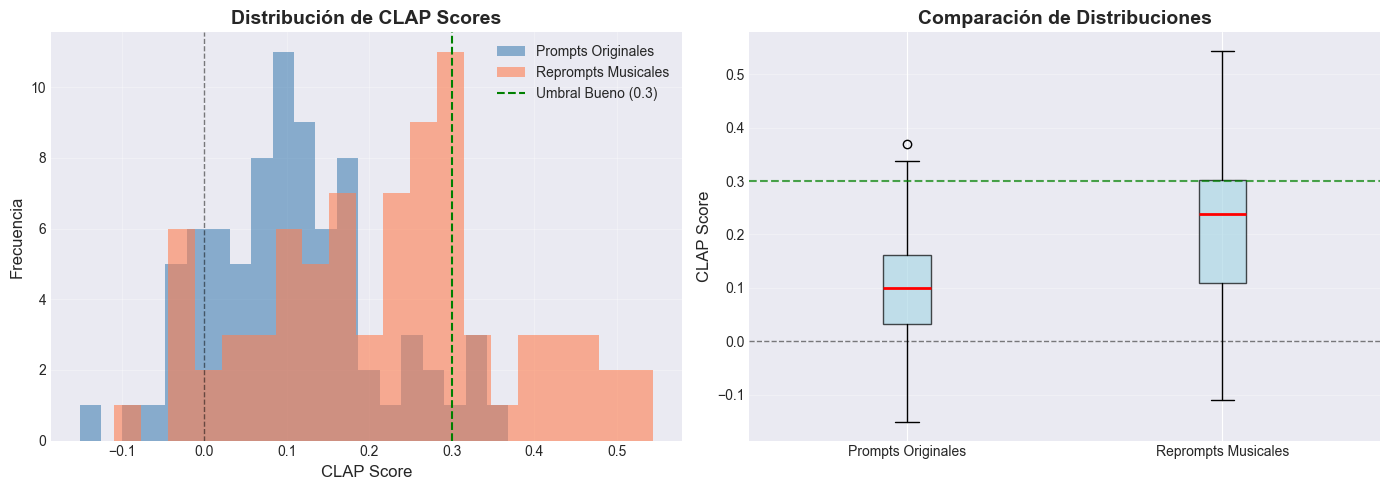

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(prompt_df['clap_score'], bins=20, alpha=0.6, label='Prompts Originales', color='steelblue')
axes[0].hist(reprompt_df['clap_score'], bins=20, alpha=0.6, label='Reprompts Musicales', color='coral')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(0.3, color='green', linestyle='--', linewidth=1.5, label='Umbral Bueno (0.3)')
axes[0].set_xlabel('CLAP Score', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de CLAP Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)


data_to_plot = [prompt_df['clap_score'], reprompt_df['clap_score']]
axes[1].boxplot(data_to_plot, labels=['Prompts Originales', 'Reprompts Musicales'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(0.3, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('CLAP Score', fontsize=12)
axes[1].set_title('Comparación de Distribuciones', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('clap_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

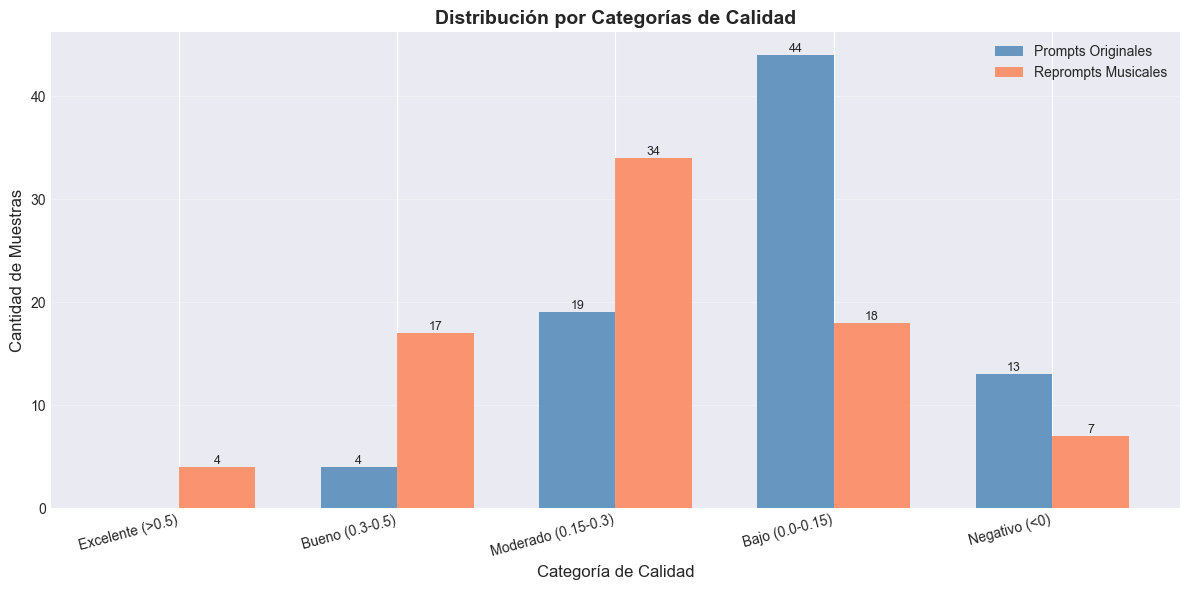

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(categories_df))
width = 0.35

bars1 = ax.bar(x - width/2, categories_df['Prompts Originales'], width, 
               label='Prompts Originales', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, categories_df['Reprompts Musicales'], width, 
               label='Reprompts Musicales', alpha=0.8, color='coral')

ax.set_xlabel('Categoría de Calidad', fontsize=12)
ax.set_ylabel('Cantidad de Muestras', fontsize=12)
ax.set_title('Distribución por Categorías de Calidad', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_df.index, rotation=15, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('clap_score_categories.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Análisis de Mejores y Peores Casos

In [10]:
print("TOP 5 MEJORES SCORES - PROMPTS ORIGINALES")
display(prompt_df.nlargest(5, 'clap_score')[['id_prompt', 'clap_score', 'text']])

TOP 5 MEJORES SCORES - PROMPTS ORIGINALES


,id_prompt,clap_score,text
78,79,0.368809,I feel fear and I'm gonna drink a glass of lem...
10,11,0.337792,I'm gonna eat a chocolate cake at the balcony....
18,19,0.334433,I feel fear and I'm gonna eat a caramel popcor...
69,70,0.326069,I feel anger and I'm gonna eat a bowl of cevic...
38,39,0.293507,I feel fear and I'm gonna drink a strong herba...


In [11]:
print("TOP 5 MEJORES SCORES - REPROMPTS MUSICALES")
display(reprompt_df.nlargest(5, 'clap_score')[['id_prompt', 'clap_score', 'text']])

TOP 5 MEJORES SCORES - REPROMPTS MUSICALES


,id_prompt,clap_score,text
76,77,0.544025,"Mellow marimba lead, bright timbre, mid-range ..."
55,56,0.541244,"Biting synth lead, metallic bright timbre, sha..."
77,78,0.503491,"Mellow marimba, bright wooden timbre, mid-high..."
67,68,0.502949,"Mellow marimba melody, bright warm timbre, mid..."
37,38,0.476969,"sweet sounding melody, acoustic guitar lead, b..."


### Hallazgo 2: Sesgo Instrumental

**Los mejores resultados con reprompts musicales están dominados por marimba**, con 4 de los 5 mejores scores (0.476 a 0.544) describiendo este instrumento. Esto sugiere que el modelo tasty-musicgen-small tiene particular éxito generando audio que se alinea con descripciones de este instrumento de percusión melódica.

Otros instrumentos exitosos incluyen acoustic guitar (0.477) y synth lead (0.541).


In [12]:
print("TOP 5 PEORES SCORES - PROMPTS ORIGINALES")
display(prompt_df.nsmallest(5, 'clap_score')[['id_prompt', 'clap_score', 'text']])

TOP 5 PEORES SCORES - PROMPTS ORIGINALES


,id_prompt,clap_score,text
55,56,-0.151538,I feel surprise and I'm gonna eat a bowl of mi...
73,74,-0.094644,I'm at the restaurant and I'm gonna eat a jar ...
50,51,-0.071944,I'm gonna eat a bag of potato chips at the tra...
48,49,-0.043681,I'm at the beach and I'm gonna eat a bacon san...
42,43,-0.038418,I'm in the cafe with my brother and we're gonn...


In [13]:
print("TOP 5 PEORES SCORES - REPROMPTS MUSICALES")
display(reprompt_df.nsmallest(5, 'clap_score')[['id_prompt', 'clap_score', 'text']])

TOP 5 PEORES SCORES - REPROMPTS MUSICALES


,id_prompt,clap_score,text
71,72,-0.109971,"harmonium melody, warm reedy timbre, mid-high ..."
64,65,-0.043853,"Breathy harmonium melody, warm mid-range timbr..."
53,54,-0.043431,"crystalline harp melody in mid-register, shimm..."
13,14,-0.040433,"Flute lead, warm bright timbre, mid-high pitch..."
57,58,-0.033088,"Crisp ukulele leads joyful, sweet sounding mel..."


## 6. Comparación Par a Par (Mismo Prompt ID)

In [14]:
merged = prompt_df.merge(reprompt_df, on='id_prompt', suffixes=('_orig', '_reprompt'))
merged['improvement'] = merged['clap_score_reprompt'] - merged['clap_score_orig']
merged['improvement_pct'] = (merged['improvement'] / merged['clap_score_orig'].abs()) * 100

print(f"Total de pares analizados: {len(merged)}")
print(f"Casos donde reprompt MEJORÓ: {(merged['improvement'] > 0).sum()} ({(merged['improvement'] > 0).sum()/len(merged)*100:.1f}%)")
print(f"Casos donde reprompt EMPEORÓ: {(merged['improvement'] < 0).sum()} ({(merged['improvement'] < 0).sum()/len(merged)*100:.1f}%)")
print(f"Mejora promedio: {merged['improvement'].mean():+.3f}")
print(f"Mejora mediana: {merged['improvement'].median():+.3f}")
print(f"Desviación estándar de mejoras: {merged['improvement'].std():.3f}")

Total de pares analizados: 80
Casos donde reprompt MEJORÓ: 56 (70.0%)
Casos donde reprompt EMPEORÓ: 24 (30.0%)
Mejora promedio: +0.118
Mejora mediana: +0.091
Desviación estándar de mejoras: 0.185


In [15]:
print("TOP 5 MAYORES MEJORAS (Reprompt vs Original)")
top_improvements = merged.nlargest(5, 'improvement')[[
    'id_prompt', 'clap_score_orig', 'clap_score_reprompt', 'improvement', 'improvement_pct', 'text_orig'
]]
display(top_improvements)

TOP 5 MAYORES MEJORAS (Reprompt vs Original)


,id_prompt,clap_score_orig,clap_score_reprompt,improvement,improvement_pct,text_orig
55,56,-0.151538,0.541244,0.692782,457.167034,I feel surprise and I'm gonna eat a bowl of mi...
77,78,-0.017297,0.503491,0.520787,3010.915736,I'm at the beach and I'm gonna eat a green app...
79,80,-0.038122,0.430227,0.468349,1228.552972,I'm in the park with a neighbor and we're gonn...
35,36,0.013526,0.449640,0.436115,3224.376036,I feel surprise and I'm gonna eat a bitter mel...
16,17,0.033603,0.431613,0.398011,1184.457706,I'm gonna eat a fruit salad at the office. The...


### Hallazgo 3: Transformaciones Significativas

El reprompt musical puede transformar completamente resultados fallidos:
- **Caso ID 56**: Score pasa de -0.152 a 0.541 (+0.693 puntos, mejora del 457%)
- **Caso ID 78**: Score pasa de -0.017 a 0.503 (+0.521 puntos, mejora del 3011%)
- **Caso ID 80**: Score pasa de -0.038 a 0.430 (+0.468 puntos, mejora del 1229%)

Estos casos demuestran el potencial del reprompting cuando el modelo logra interpretar correctamente las descripciones musicales detalladas.


In [16]:
print("TOP 5 PEORES CAMBIOS (Reprompt peor que Original)")
worst_changes = merged.nsmallest(5, 'improvement')[[
    'id_prompt', 'clap_score_orig', 'clap_score_reprompt', 'improvement', 'improvement_pct', 'text_orig'
]]
display(worst_changes)

TOP 5 PEORES CAMBIOS (Reprompt peor que Original)


,id_prompt,clap_score_orig,clap_score_reprompt,improvement,improvement_pct,text_orig
64,65,0.208961,-0.043853,-0.252814,-120.985970,I'm gonna eat a slice of sourdough bread at th...
26,27,0.212884,0.007285,-0.205600,-96.578052,I feel contempt and I'm gonna eat a grapefruit...
13,14,0.153976,-0.040433,-0.194410,-126.259399,I feel contempt and I'm gonna eat a honey glaz...
7,8,0.264459,0.109734,-0.154725,-58.506094,I'm in the cafe with my brother and we're gonn...
21,22,0.184571,0.049477,-0.135094,-73.193573,I feel surprise and I'm gonna drink a black co...


### Hallazgo 4: Alta Varianza y Casos de Fallo

El reprompt musical introduce **alta varianza**:
- 30% de los casos empeoran con reprompt (24 casos de 80)
- Algunos casos experimentan degradaciones significativas:
  - ID 65: -0.253 puntos (-121% de deterioro)
  - ID 27: -0.206 puntos (-97% de deterioro)
  - ID 14: -0.194 puntos (-126% de deterioro)

Esto sugiere que descripciones muy técnicas o ciertos timbres están fuera del dominio efectivo del modelo.


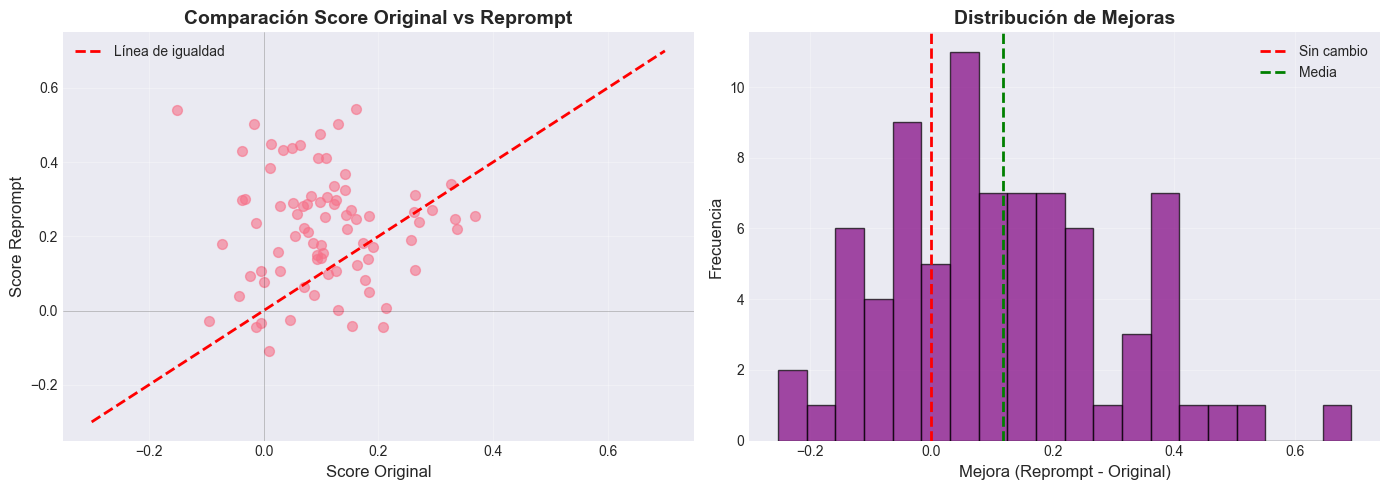

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(merged['clap_score_orig'], merged['clap_score_reprompt'], alpha=0.6, s=50)
axes[0].plot([-0.3, 0.7], [-0.3, 0.7], 'r--', linewidth=2, label='Línea de igualdad')
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_xlabel('Score Original', fontsize=12)
axes[0].set_ylabel('Score Reprompt', fontsize=12)
axes[0].set_title('Comparación Score Original vs Reprompt', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].hist(merged['improvement'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Sin cambio')
axes[1].axvline(merged['improvement'].mean(), color='green', linestyle='--', linewidth=2, label='Media')
axes[1].set_xlabel('Mejora (Reprompt - Original)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Mejoras', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clap_score_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Resumen de Hallazgos Principales

1. Mejora Promedio del Reprompt: +112%
   - El reprompt musical aumenta el CLAP Score promedio de 0.1047 a 0.2224 (+0.1177 puntos)
   - La mediana mejora de 0.0992 a 0.2382 (+140%)
   - Mejora estadísticamente significativa (p < 0.000001, t = 5.70)

2. Multiplicación de Resultados de Calidad
   - Resultados buenos/excelentes: 5% → 26.2% (5.2x aumento)
   - 4 casos alcanzan scores excelentes (>0.5) con reprompt vs. 0 con prompts originales
   - Resultados negativos reducidos de 16.2% a 8.8%

3. Efectividad Consistente
   - 70% de casos mejoran con reprompt (56 de 80)
   - La mejora mediana es de +0.091 puntos
   - Los casos con scores originales más bajos experimentan las mayores mejoras absolutas


---

### Conclusiones

El reprompting musical con tasty-musicgen-small es altamente efectivo para mejorar la alineación texto-audio medida por CLAP Score. 

Con una mejora promedio de +112% y un 70% de tasa de éxito, el enfoque demuestra que:

1. Las descripciones musicales técnicas son más interpretables que escenarios narrativos para el modelo
2. El modelo tiene fortalezas específicas (marimba, instrumentos melódicos de percusión)
3. El reprompting es especialmente valioso para casos con bajo rendimiento inicial
4. Existe espacio de mejora en la consistencia, particularmente para ciertos timbres e instrumentos
